In [1]:
import numpy as np
import pandas as pd
import nmrglue as ng
import nibabel as nib

import matplotlib.pyplot as plt

from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.cluster import KMeans

from sklearn.metrics import adjusted_mutual_info_score as AMI

from nmrglue.process.proc_base import fft
from contrastive import CPCA
import imageio
import ants
import pickle

In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "2"
os.environ["MKL_NUM_THREADS"] = "2"
os.environ["OPENBLAS_NUM_THREADS"] = "2"

In [22]:
ms1 = nib.load("/data/MRSI/Naren2/MRSI/RMS01_V3/RMS01_complex_FFT_redone.nii")
ms2 = nib.load("/data/MRSI/Naren2/MRSI/RMS01_V3/RMS01_REF_complex_FFT_redone.nii")

In [24]:
ms1_arr = np.array(ms1.dataobj)
ms2_arr = np.array(ms2.dataobj)

In [25]:
ms1_arr.shape
ms2_arr.shape

(32, 4096, 2048, 2)

In [26]:
RMS01_arr = ms1_arr.reshape(32,64,64,2048,2)
RMS02_arr = ms2_arr.reshape(32,64,64,2048,2)


In [27]:
RMS01_complex_sum = (RMS01_arr[:,:,:,:,0]**2 + RMS01_arr[:,:,:,:,1]**2)**(1/2)
RMS02_complex_sum = (RMS02_arr[:,:,:,:,0]**2 + RMS02_arr[:,:,:,:,1]**2)**(1/2)


In [15]:
RMS01_complex_sum.shape

(32, 64, 64, 2048)

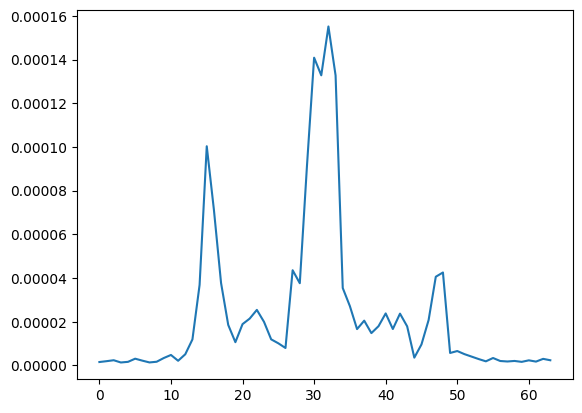

In [30]:
plt.plot(RMS01_complex_sum[16,32,:,1200])

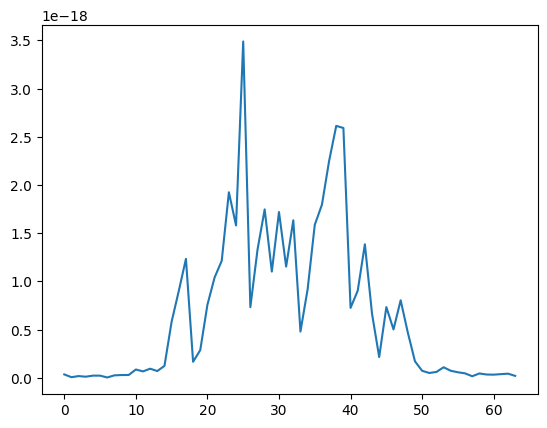

In [31]:
plt.plot(RMS02_complex_sum[16,32,:,1200])

In [ ]:
#saving (samples, features for CPCA)
import nibabel as nib
ni_img = nib.Nifti1Image(RMS01_complex_sum, affine=np.eye(4))
nib.save(ni_img, "/data/bioprotean/Naren2/FURI2/mayomrs_aligned/Control/Control04/Control04_complex_sum_redone.nii")

In [11]:
postwarp = nib.load('/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS02/RMS02_flair_overlay_norm_Warped.nii.gz').dataobj

In [ ]:
#saving (samples, features for CPCA)
import nibabel as nib
ni_img = nib.Nifti1Image(postwarp_tp, affine=np.eye(4))
nib.save(ni_img, "/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS02/RMS02_flair_warped.nii")

In [8]:
#import complex sum for control and ms patients
RMS01_complex_sum = nib.load("/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS01/RMS01_complex_sum_redone.nii").dataobj
RMS02_complex_sum = nib.load("/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS02/RMS02_complex_sum_redone.nii").dataobj
RMS03_complex_sum = nib.load("/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS03/RMS03_complex_sum_redone.nii").dataobj
RMS05_complex_sum = nib.load("/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS05/RMS05_complex_sum_redone.nii").dataobj
Control01_complex_sum = nib.load("/data/MRSI/Naren2/FURI2/mayomrs_aligned/Control/Control01/Control01_complex_sum_redone.nii").dataobj
Control02_complex_sum = nib.load("/data/MRSI/Naren2/FURI2/mayomrs_aligned/Control/Control02/Control02_complex_sum_redone.nii").dataobj
Control03_complex_sum = nib.load("/data/MRSI/Naren2/FURI2/mayomrs_aligned/Control/Control03/Control03_complex_sum_redone.nii").dataobj
Control04_complex_sum = nib.load("/data/MRSI/Naren2/FURI2/mayomrs_aligned/Control/Control04/Control04_complex_sum_redone.nii").dataobj

In [156]:
#import handtraced hyperintensity labels in spectra space
msl1_arr = np.array(nib.load("/data/MRSI/Naren2/MRSI/RMS01_V3/RMS01_labels2spectra.nii").dataobj)
msl2_arr = np.array(nib.load("/data/MRSI/Naren2/MRSI/RMS02_V3/RMS02_labels2spectra.nii").dataobj)
msl3_arr = np.array(nib.load("/data/MRSI/Naren2/MRSI/RMS03_V3/RMS03_labels2spectra.nii").dataobj)
msl5_arr = np.array(nib.load("/data/MRSI/Naren2/MRSI/RMS05_V3/RMS05_labels2spectra.nii").dataobj)

In [157]:
msl1_arr.shape

(32, 64, 64)

In [12]:
postwarp_tp = np.transpose(postwarp)

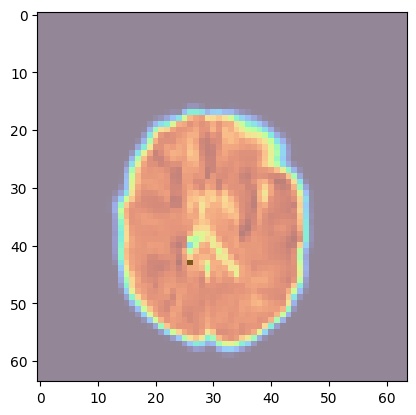

In [13]:
plt.imshow(postwarp_tp[16,:,:], cmap='turbo')
plt.imshow(msl1_arr[16,:,:], alpha=0.5,cmap='Greens')

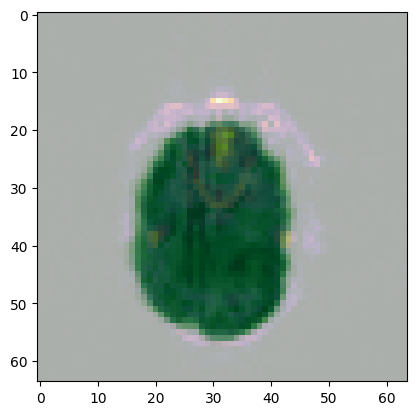

In [14]:
#unwarped vs spectral sum
plt.imshow(RMS01_complex_sum[20,:,:,750],cmap='inferno')
plt.imshow(postwarp_tp[20,:,:], alpha=0.7,cmap='Greens')
#plt.imshow(msl1_arr[:,30,:], alpha=0.3,cmap='Greens')

In [15]:
#making empty lists
ms1_hy_arrays = []
ms1_bgd_arrays = []
ms2_hy_arrays = []
ms2_bgd_arrays = []
ms3_hy_arrays = []
ms3_bgd_arrays = []
ms5_hy_arrays = []
ms5_bgd_arrays = []

In [16]:
#iterating through spectra to extract the spectral data only where label is present
for n in range(0,2048):
    ms1_arr_masked_temp_hy = np.ma.masked_where(msl1_arr<1, RMS01_complex_sum[:,:,:,n]) #mask values that are less than 1 in spectral data (gives hyperintensities)
    hy1_mask = np.ma.getmask(ms1_arr_masked_temp_hy) #get only mask (True False) values
    hy1_mask_applied = np.where(hy1_mask, 0, ms1_arr_masked_temp_hy) #where mask is True (and value is 'masked'), make it 0 and keep everything else
    ms1_hy_arrays.append(hy1_mask_applied)
    ms1_arr_masked_temp_bgd = np.ma.masked_where(msl1_arr>0, RMS01_complex_sum[:,:,:,n]) #mask values that are greater than 0 in spectral data (gives background)
    bgd1_mask = np.ma.getmask(ms1_arr_masked_temp_bgd)
    bg1_mask_applied = np.where(bgd1_mask, 0, ms1_arr_masked_temp_bgd)
    ms1_bgd_arrays.append(bg1_mask_applied)

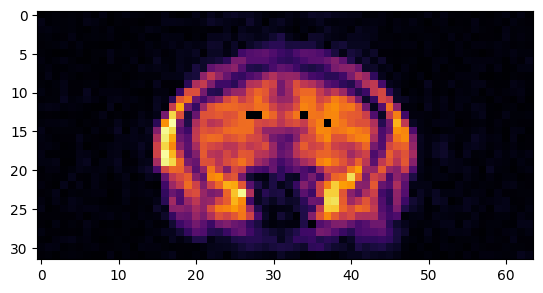

In [18]:
#This is reference dataset
#unwarped vs spectral sum
plt.imshow(ms1_bgd_arrays[750][:,30,:],cmap='inferno')
plt.imshow(msl1_arr[:,30,:], alpha=0,cmap='Greens')

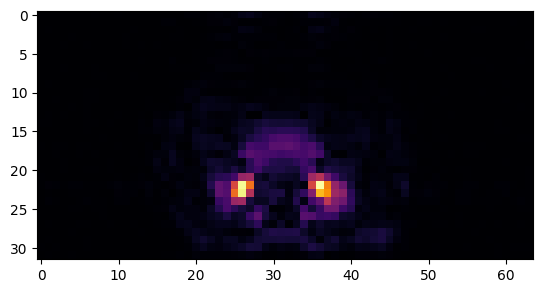

In [ ]:
#This is Water Supressed dataset
#unwarped vs spectral sum
plt.imshow(ms1_bgd_arrays[750][:,30,:],cmap='inferno')
plt.imshow(msl1_arr[:,30,:], alpha=0,cmap='Greens')

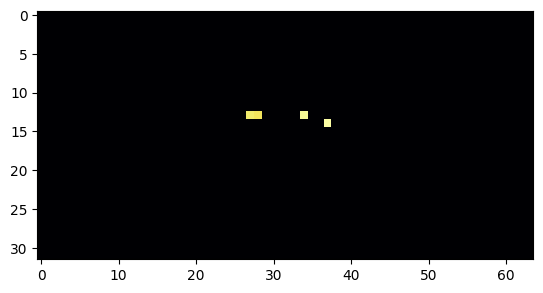

In [19]:
plt.imshow(ms1_hy_arrays[750][:,30,:],cmap='inferno')

In [24]:
#making mask for different voxel spectra's into one array
ms1_arr_masked_hy = np.stack(ms1_hy_arrays, axis=3)
ms1_arr_masked_bgd = np.stack(ms1_bgd_arrays, axis=3)

In [25]:
#saving RMS01 files
np.save('/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS01/redo/ms1_arr_masked_hy_ws.npy',ms1_arr_masked_hy)
np.save('/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS01/redo/ms1_arr_masked_bgd_ws.npy',ms1_arr_masked_bgd)

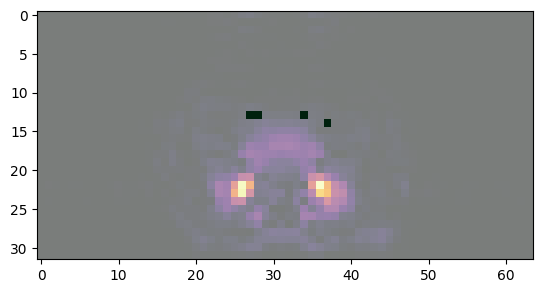

In [26]:
#unwarped vs spectral sum
plt.imshow(ms1_arr_masked_bgd[:,30,:,750],cmap='inferno')
plt.imshow(msl1_arr[:,30,:], alpha=0.5,cmap='Greens')

In [27]:
np.array_equal(ms1_arr_masked_hy,ms1_arr_masked_bgd)

False

In [28]:
for n in range(0,2048):
    ms2_arr_masked_temp_hy = np.ma.masked_where(msl2_arr<1, RMS02_complex_sum[:,:,:,n]) #mask values that are less than 1 in spectral data (gives hyperintensities)
    hy2_mask = np.ma.getmask(ms2_arr_masked_temp_hy) #get only mask (True False) values
    hy2_mask_applied = np.where(hy2_mask, 0, ms2_arr_masked_temp_hy) #where mask is True (and value is 'masked'), make it 0 and keep everything else
    ms2_hy_arrays.append(hy2_mask_applied)
    ms2_arr_masked_temp_bgd = np.ma.masked_where(msl2_arr>0, RMS02_complex_sum[:,:,:,n]) #mask values that are greater than 0 in spectral data (gives background)
    bgd2_mask = np.ma.getmask(ms2_arr_masked_temp_bgd)
    bg2_mask_applied = np.where(bgd2_mask, 0, ms2_arr_masked_temp_bgd)
    ms2_bgd_arrays.append(bg2_mask_applied)

In [29]:
ms2_arr_masked_hy = np.stack(ms2_hy_arrays, axis=3)
ms2_arr_masked_bgd = np.stack(ms2_bgd_arrays, axis=3)

In [30]:
#saving RMS02 files
np.save('/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS02/redo/ms2_arr_masked_hy_ws.npy',ms2_arr_masked_hy)
np.save('/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS02/redo/ms2_arr_masked_bgd_ws.npy',ms2_arr_masked_bgd)

In [31]:
for n in range(0,2048):
    ms3_arr_masked_temp_hy = np.ma.masked_where(msl3_arr<1, RMS03_complex_sum[:,:,:,n]) #mask values that are less than 1 in spectral data (gives hyperintensities)
    hy3_mask = np.ma.getmask(ms3_arr_masked_temp_hy) #get only mask (True False) values
    hy3_mask_applied = np.where(hy3_mask, 0, ms3_arr_masked_temp_hy) #where mask is True (and value is 'masked'), make it 0 and keep everything else
    ms3_hy_arrays.append(hy3_mask_applied)
    ms3_arr_masked_temp_bgd = np.ma.masked_where(msl3_arr>0, RMS03_complex_sum[:,:,:,n]) #mask values that are greater than 0 in spectral data (gives background)
    bgd3_mask = np.ma.getmask(ms3_arr_masked_temp_bgd)
    bg3_mask_applied = np.where(bgd3_mask, 0, ms3_arr_masked_temp_bgd)
    ms3_bgd_arrays.append(bg3_mask_applied)

In [32]:
ms3_arr_masked_hy = np.stack(ms3_hy_arrays, axis=3)
ms3_arr_masked_bgd = np.stack(ms3_bgd_arrays, axis=3)

In [33]:
#saving RMS03 files
np.save('/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS03/redo/ms3_arr_masked_hy_ws.npy',ms3_arr_masked_hy)
np.save('/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS03/redo/ms3_arr_masked_bgd_ws.npy',ms3_arr_masked_bgd)

In [34]:
for n in range(0,2048):
    ms5_arr_masked_temp_hy = np.ma.masked_where(msl5_arr<1, RMS05_complex_sum[:,:,:,n]) #mask values that are less than 1 in spectral data (gives hyperintensities)
    hy5_mask = np.ma.getmask(ms5_arr_masked_temp_hy) #get only mask (True False) values
    hy5_mask_applied = np.where(hy5_mask, 0, ms5_arr_masked_temp_hy) #where mask is True (and value is 'masked'), make it 0 and keep everything else
    ms5_hy_arrays.append(hy5_mask_applied)
    ms5_arr_masked_temp_bgd = np.ma.masked_where(msl5_arr>0, RMS05_complex_sum[:,:,:,n]) #mask values that are greater than 0 in spectral data (gives background)
    bgd5_mask = np.ma.getmask(ms5_arr_masked_temp_bgd)
    bg5_mask_applied = np.where(bgd5_mask, 0, ms5_arr_masked_temp_bgd)
    ms5_bgd_arrays.append(bg5_mask_applied)

In [35]:
ms5_arr_masked_hy = np.stack(ms5_hy_arrays, axis=3)
ms5_arr_masked_bgd = np.stack(ms5_bgd_arrays, axis=3)

In [36]:
#saving RMS05 files
np.save('/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS05/redo/ms5_arr_masked_hy_ws.npy',ms5_arr_masked_hy)
np.save('/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS05/redo/ms5_arr_masked_bgd_ws.npy',ms5_arr_masked_bgd)

In [37]:
#loading control .nii files
Control01_complex_sum = nib.load("/data/MRSI/Naren2/FURI2/mayomrs_aligned/Control/Control01/Control01_complex_sum_redone.nii")
Control02_complex_sum = nib.load("/data/MRSI/Naren2/FURI2/mayomrs_aligned/Control/Control02/Control02_complex_sum_redone.nii")
Control03_complex_sum = nib.load("/data/MRSI/Naren2/FURI2/mayomrs_aligned/Control/Control03/Control03_complex_sum_redone.nii")
Control04_complex_sum = nib.load("/data/MRSI/Naren2/FURI2/mayomrs_aligned/Control/Control04/Control04_complex_sum_redone.nii")

In [38]:
#converting to array
Control01_complex_sum_arr = np.array(Control01_complex_sum.dataobj)
Control02_complex_sum_arr = np.array(Control02_complex_sum.dataobj)
Control03_complex_sum_arr = np.array(Control03_complex_sum.dataobj)
Control04_complex_sum_arr = np.array(Control04_complex_sum.dataobj)

In [39]:
#saving control sums as .npy so it's easier to load in
np.save('/data/MRSI/Naren2/FURI2/mayomrs_aligned/Control/Control01/Control01_complex_sum_ws.npy',Control01_complex_sum_arr)
np.save('/data/MRSI/Naren2/FURI2/mayomrs_aligned/Control/Control02/Control02_complex_sum_ws.npy',Control02_complex_sum_arr)
np.save('/data/MRSI/Naren2/FURI2/mayomrs_aligned/Control/Control03/Control03_complex_sum_ws.npy',Control03_complex_sum_arr)
np.save('/data/MRSI/Naren2/FURI2/mayomrs_aligned/Control/Control04/Control04_complex_sum_ws.npy',Control04_complex_sum_arr)

In [40]:
#loading all necessary files in one cell                                                                                                                    ###############
ms1_arr_masked_hy = np.load('/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS01/redo/ms1_arr_masked_hy_ws.npy')
ms2_arr_masked_hy = np.load('/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS02/redo/ms2_arr_masked_hy_ws.npy')
ms3_arr_masked_hy = np.load('/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS03/redo/ms3_arr_masked_hy_ws.npy')
ms5_arr_masked_hy = np.load('/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS05/redo/ms5_arr_masked_hy_ws.npy')
ms1_arr_masked_bgd = np.load('/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS01/redo/ms1_arr_masked_bgd_ws.npy')
ms2_arr_masked_bgd = np.load('/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS02/redo/ms2_arr_masked_bgd_ws.npy')
ms3_arr_masked_bgd = np.load('/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS03/redo/ms3_arr_masked_bgd_ws.npy')
ms5_arr_masked_bgd = np.load('/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS05/redo/ms5_arr_masked_bgd_ws.npy')

In [43]:
#loading in saved files
Control01_complex_sum = np.load('/data/MRSI/Naren2/FURI2/mayomrs_aligned/Control/Control01/Control01_complex_sum_ws.npy')
Control02_complex_sum = np.load('/data/MRSI/Naren2/FURI2/mayomrs_aligned/Control/Control02/Control02_complex_sum_ws.npy')
Control03_complex_sum = np.load('/data/MRSI/Naren2/FURI2/mayomrs_aligned/Control/Control03/Control03_complex_sum_ws.npy')
Control04_complex_sum = np.load('/data/MRSI/Naren2/FURI2/mayomrs_aligned/Control/Control04/Control04_complex_sum_ws.npy')

In [44]:
#reshaping before concatenating
ms1_arr_masked_hy_re = ms1_arr_masked_hy.reshape(32*64*64,2048)
ms2_arr_masked_hy_re = ms2_arr_masked_hy.reshape(32*64*64,2048)
ms3_arr_masked_hy_re = ms3_arr_masked_hy.reshape(32*64*64,2048)
ms5_arr_masked_hy_re = ms5_arr_masked_hy.reshape(32*64*64,2048)
ms1_arr_masked_bgd_re = ms1_arr_masked_bgd.reshape(32*64*64,2048)
ms2_arr_masked_bgd_re = ms2_arr_masked_bgd.reshape(32*64*64,2048)
ms3_arr_masked_bgd_re = ms3_arr_masked_bgd.reshape(32*64*64,2048)
ms5_arr_masked_bgd_re = ms5_arr_masked_bgd.reshape(32*64*64,2048)

In [45]:
#saving masked arrays which are reshaped as .npy so it's easier to load in
np.save('/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS01/redo/ms1_arr_masked_hy_re_ws.npy',ms1_arr_masked_hy_re)
np.save('/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS02/redo/ms2_arr_masked_hy_re_ws.npy',ms2_arr_masked_hy_re)
np.save('/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS03/redo/ms3_arr_masked_hy_re_ws.npy',ms3_arr_masked_hy_re)
np.save('/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS05/redo/ms5_arr_masked_hy_re_ws.npy',ms5_arr_masked_hy_re)
np.save('/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS01/redo/ms1_arr_masked_bgd_re_ws.npy',ms1_arr_masked_bgd_re)
np.save('/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS02/redo/ms2_arr_masked_bgd_re_ws.npy',ms2_arr_masked_bgd_re)
np.save('/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS03/redo/ms3_arr_masked_bgd_re_ws.npy',ms3_arr_masked_bgd_re)
np.save('/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS05/redo/ms5_arr_masked_bgd_re_ws.npy',ms5_arr_masked_bgd_re)

In [46]:
Control01_complex_sum_re = Control01_complex_sum.reshape(32*64*64,2048)
Control02_complex_sum_re = Control02_complex_sum.reshape(32*64*64,2048)
Control03_complex_sum_re = Control03_complex_sum.reshape(32*64*64,2048)
Control04_complex_sum_re = Control04_complex_sum.reshape(32*64*64,2048)

In [47]:
#saving control sums reshaped as .npy so it's easier to load in
np.save('/data/MRSI/Naren2/FURI2/mayomrs_aligned/Control/Control01/Control01_complex_sum_re_ws.npy',Control01_complex_sum_re)
np.save('/data/MRSI/Naren2/FURI2/mayomrs_aligned/Control/Control02/Control02_complex_sum_re_ws.npy',Control02_complex_sum_re)
np.save('/data/MRSI/Naren2/FURI2/mayomrs_aligned/Control/Control03/Control03_complex_sum_re_ws.npy',Control03_complex_sum_re)
np.save('/data/MRSI/Naren2/FURI2/mayomrs_aligned/Control/Control04/Control04_complex_sum_re_ws.npy',Control04_complex_sum_re)

In [3]:
#loading all reshaped files in one cell
ms1_arr_masked_hy_re = np.load('/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS01/redo/ms1_arr_masked_hy_re_ws.npy')
ms2_arr_masked_hy_re = np.load('/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS02/redo/ms2_arr_masked_hy_re_ws.npy')
ms3_arr_masked_hy_re = np.load('/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS03/redo/ms3_arr_masked_hy_re_ws.npy')
ms5_arr_masked_hy_re = np.load('/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS05/redo/ms5_arr_masked_hy_re_ws.npy')
ms1_arr_masked_bgd_re = np.load('/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS01/redo/ms1_arr_masked_bgd_re_ws.npy')
ms2_arr_masked_bgd_re = np.load('/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS02/redo/ms2_arr_masked_bgd_re_ws.npy')
ms3_arr_masked_bgd_re = np.load('/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS03/redo/ms3_arr_masked_bgd_re_ws.npy')
ms5_arr_masked_bgd_re = np.load('/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS05/redo/ms5_arr_masked_bgd_re_ws.npy')
Control01_complex_sum_re = np.load('/data/MRSI/Naren2/FURI2/mayomrs_aligned/Control/Control01/Control01_complex_sum_re_ws.npy')
Control02_complex_sum_re = np.load('/data/MRSI/Naren2/FURI2/mayomrs_aligned/Control/Control02/Control02_complex_sum_re_ws.npy')
Control03_complex_sum_re = np.load('/data/MRSI/Naren2/FURI2/mayomrs_aligned/Control/Control03/Control03_complex_sum_re_ws.npy')
Control04_complex_sum_re = np.load('/data/MRSI/Naren2/FURI2/mayomrs_aligned/Control/Control04/Control04_complex_sum_re_ws.npy')

In [138]:
ms1_ind = np.nonzero(ms1_arr_masked_hy_re)

In [140]:
ms1_arr_masked_hy_re.shape

(131072, 2048)

In [139]:
ms1_ind[0].shape

(165888,)

In [4]:
np.count_nonzero(ms1_arr_masked_hy_re)

165888

In [80]:
ms2 = ms2_arr_masked_hy_re.reshape(32,64,64,2048)

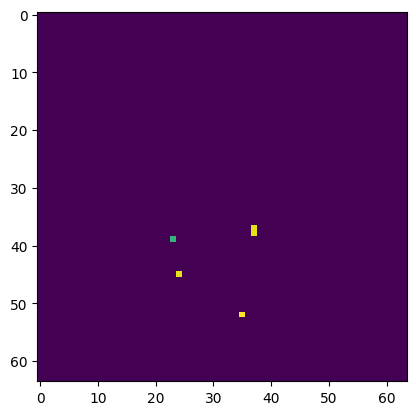

In [81]:
plt.imshow(ms2[16,:,:,2000])

In [130]:
hy_frame.shape

(524288, 2048)

In [132]:
hy_frame_ind = np.nonzero(hy_frame.real)

In [136]:
hy_frame_ind[0].shape

(337920,)

In [137]:
hy_frame_ind[1].shape

(337920,)

In [6]:
np.count_nonzero(ms3_arr_masked_hy_re)

43008

In [7]:
np.count_nonzero(ms5_arr_masked_hy_re)

12288

In [4]:
#making a frame for PCA/CPCA. bgd frame is all background data, including control and non-hyperintensity MS. hy_frame is only hyperintensity from ms brain
#bgd_frame = np.concatenate((Control01_complex_sum_re,Control02_complex_sum_re,Control03_complex_sum_re,Control04_complex_sum_re, ms1_arr_masked_bgd_re, ms2_arr_masked_bgd_re, ms3_arr_masked_bgd_re, ms5_arr_masked_bgd_re), axis=0)
hy_frame = np.concatenate((ms1_arr_masked_hy_re, ms2_arr_masked_hy_re, ms3_arr_masked_hy_re, ms5_arr_masked_hy_re), axis=0)
#, ms3_arr_masked_hy_re, ms5_arr_masked_hy_re

In [5]:
#making more frames. bgd_frame_onlyc doesn't use non-hyperintensity MS, only control. hy_frame_allms uses all hyperintensity data, including non-hyperintensity MS
bgd_frame_onlyc = np.concatenate((Control01_complex_sum_re,Control02_complex_sum_re,Control03_complex_sum_re,Control04_complex_sum_re), axis=0)
#hy_frame_allms = np.concatenate((ms1_arr_masked_hy_re, ms2_arr_masked_hy_re, ms3_arr_masked_hy_re, ms5_arr_masked_hy_re, ms1_arr_masked_bgd_re, ms2_arr_masked_bgd_re, ms3_arr_masked_bgd_re, ms5_arr_masked_bgd_re), axis=0)
#, ms3_arr_masked_hy_re, ms5_arr_masked_hy_re
#, ms3_arr_masked_bgd_re, ms5_arr_masked_bgd_re

In [40]:
np.count_nonzero(hy_frame)

337920

In [42]:
np.count_nonzero(hy_frame==0)

1073403904

In [5]:
#ms everything outside hy
bgd_onlyms = np.concatenate((ms1_arr_masked_bgd_re, ms2_arr_masked_bgd_re, ms3_arr_masked_bgd_re, ms5_arr_masked_bgd_re), axis=0)

In [6]:
#print(bgd_frame.shape)
print(bgd_frame_onlyc.shape)
print(hy_frame.shape)
#print(hy_frame_allms.shape)

(524288, 2048)
(524288, 2048)


In [7]:
#ensure main frame and background frame have same dimensionality
#print(bgd_frame.real.shape[1]==hy_frame.real.shape[1])
#print(bgd_frame_onlyc.real.shape[1]==hy_frame.real.shape[1])
print(bgd_frame_onlyc.real.shape[1]==hy_frame_allms.real.shape[1])

True


In [6]:
print(bgd_frame_onlyc.real.shape[1]==hy_frame.real.shape[1])

True


In [ ]:
#making memory for CPCA
del ms1_arr_masked_hy_re
del ms2_arr_masked_hy_re
del ms3_arr_masked_hy_re
del ms5_arr_masked_hy_re
del ms1_arr_masked_bgd_re
del ms2_arr_masked_bgd_re
del ms3_arr_masked_bgd_re
del ms5_arr_masked_bgd_re
del Control01_complex_sum_re
del Control02_complex_sum_re
del Control03_complex_sum_re
del Control04_complex_sum_re
#del bgd_frame_onlyc
#del hy_frame_allms

Different combinations of CPCA below

In [ ]:
#cpca = CPCA()
#labels = [0]*131072+[1]*131072+[2]*131072+[3]*131072
#cpca_transformed = cpca.fit_transform(hy_frame.real, bgd_frame.real, preprocess_with_pca_dim=500, plot=True, active_labels=labels, n_alphas=10)

In [9]:
cpca = CPCA()
labels = [0]*131072+[1]*131072+[2]*131072+[3]*131072+[4]*131072+[5]*131072+[6]*131072+[7]*131072
cpca_transformed = cpca.fit_transform(hy_frame_allms.real, bgd_frame_onlyc.real, plot=True, active_labels=labels, n_alphas=10)
#preprocess_with_pca_dim=500

KeyboardInterrupt: 

In [ ]:
cpca = CPCA()
labels = [0]*131072+[1]*131072+[2]*131072+[3]*131072
cpca_transformed = cpca.fit_transform(hy_frame.real, bgd_frame_onlyc.real, plot=True, active_labels=labels, n_alphas=10)
#preprocess_with_pca_dim=500

In [ ]:
#updated cpca with new labels
cpca = CPCA()
labels = [0]*131072+[1]*131072+[2]*131072+[3]*131072
cpca_transformed = cpca.fit_transform(hy_frame.real, bgd_frame_onlyc.real, plot=True, active_labels=labels, n_alphas=10,)
#preprocess_with_pca_dim=500

In [ ]:
#updated cpca with new labels
cpca = CPCA(standardize=False)
labels = [0]*131072+[1]*131072+[2]*131072+[3]*131072
cpca_transformed = cpca.fit_transform(hy_frame.real, bgd_frame_onlyc.real, plot=True, active_labels=labels, n_alphas=10,)
#preprocess_with_pca_dim=500

In [ ]:
#plotting
x = plt.scatter(principalComponents[:,1], principalComponents[:,0], c = colors)
classes = (['RMS01', 'RMS02', 'RMS03', 'RMS05'])
plt.legend(handles=x.legend_elements()[0], labels=classes)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [ ]:
#normal PCA for comparison
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(hy_frame.real)

In [ ]:
colors = [0]*131072+[1]*131072+[2]*131072+[3]*131072

In [ ]:
cpca = CPCA()
labels = [0]*131072+[1]*131072
cpca_transformed = cpca.fit_transform(hy_frame.real, bgd_frame_onlyc.real, active_labels=labels, alpha_selection='manual', alpha_value=3, n_alphas_to_return=1)
#preprocess_with_pca_dim=500

In [ ]:
cpca = CPCA()
labels = [0]*131072+[1]*131072+[2]*131072+[3]*131072
cpca_transformed2 = cpca.fit_transform(hy_frame.real, bgd_frame_onlyc.real, active_labels=labels, alpha_selection='manual', alpha_value=2, n_alphas_to_return=1)
#preprocess_with_pca_dim=500

In [ ]:
cpca = CPCA()
labels = [0]*131072+[1]*131072+[2]*131072+[3]*131072
cpca_transformed3 = cpca.fit_transform(hy_frame.real, bgd_frame_onlyc.real, active_labels=labels, alpha_selection='manual', alpha_value=3, n_alphas_to_return=1)
#preprocess_with_pca_dim=500

In [6]:
cpca = CPCA()
labels = [0]*131072+[1]*131072+[2]*131072+[3]*131072
cpca_transformed4 = cpca.fit_transform(hy_frame.real, bgd_frame_onlyc.real, active_labels=labels, alpha_selection='manual', alpha_value=1)
#preprocess_with_pca_dim=500

In [ ]:
cpca = CPCA()
labels = [0]*131072+[1]*131072+[2]*131072+[3]*131072
cpca_transformed5 = cpca.fit_transform(hy_frame.real, bgd_frame_onlyc.real, active_labels=labels, alpha_selection='manual', alpha_value=5, n_alphas_to_return=1)
#preprocess_with_pca_dim=500

In [6]:
cpca = CPCA()
labels = [0]*131072+[1]*131072+[2]*131072+[3]*131072
cpca_transformed6 = cpca.fit_transform(hy_frame.real, bgd_frame_onlyc.real, active_labels=labels, alpha_selection='manual', alpha_value=7, n_alphas_to_return=1)
#preprocess_with_pca_dim=500

In [26]:
arr = np.where(hy_frame.real == 0, np.nan, hy_frame.real)

In [6]:
cpca = CPCA()
labels = [0]*131072+[1]*131072+[2]*131072+[3]*131072
cpca_transformed7 = cpca.fit_transform(hy_frame.real, bgd_frame_onlyc.real, active_labels=labels, alpha_selection='manual', alpha_value=8, n_alphas_to_return=1)
#preprocess_with_pca_dim=500

In [70]:
#with nan on a=8
cpca = CPCA(standardize=False)
labels = [0]*131072+[1]*131072+[2]*131072+[3]*131072
cpca_transformed8 = cpca.fit_transform(hy_frame.real, bgd_frame_onlyc.real, active_labels=labels, alpha_selection='manual', alpha_value=8, n_alphas_to_return=1)
#preprocess_with_pca_dim=500

In [7]:
hy_frame.real.shape

(524288, 2048)

In [8]:
cpca_transformed7.shape

(524288, 2)

In [11]:
non_zero_indices = np.nonzero(hy_frame.real)


In [12]:
non_zero_indices

(array([ 47139,  47139,  47139, ..., 456035, 456035, 456035]),
 array([   0,    1,    2, ..., 2045, 2046, 2047]))

In [149]:
cpca_transformed7

array([[0.00696765, 0.00499513],
       [0.00696765, 0.00499513],
       [0.00696765, 0.00499513],
       ...,
       [0.00696765, 0.00499513],
       [0.00696765, 0.00499513],
       [0.00696765, 0.00499513]])

In [9]:
cpca_7 = cpca_transformed7.copy()

In [10]:
hy_frame.shape

(524288, 2048)

In [11]:
cpca_7.shape

(524288, 2)

In [12]:
np.nonzero(hy_frame.real)

(array([ 47139,  47139,  47139, ..., 456035, 456035, 456035]),
 array([   0,    1,    2, ..., 2045, 2046, 2047]))

In [13]:
#import handtraced hyperintensity labels in spectra space
msl1_arr = np.array(nib.load("/data/MRSI/Naren2/MRSI/RMS01_V3/RMS01_labels2spectra.nii").dataobj)
msl2_arr = np.array(nib.load("/data/MRSI/Naren2/MRSI/RMS02_V3/RMS02_labels2spectra.nii").dataobj)
msl3_arr = np.array(nib.load("/data/MRSI/Naren2/MRSI/RMS03_V3/RMS03_labels2spectra.nii").dataobj)
msl5_arr = np.array(nib.load("/data/MRSI/Naren2/MRSI/RMS05_V3/RMS05_labels2spectra.nii").dataobj)

In [14]:
#removing small numbers from cpca a=8
msl1_arr_re = msl1_arr.reshape(32*64*64)
msl2_arr_re = msl2_arr.reshape(32*64*64)
msl3_arr_re = msl3_arr.reshape(32*64*64)
msl5_arr_re = msl5_arr.reshape(32*64*64)
msl_frame = np.reshape(np.concatenate((msl1_arr_re, msl2_arr_re, msl3_arr_re, msl5_arr_re), axis=0), (524288, 1))

In [21]:
msl_frame.shape

(524288, 1)

In [15]:
msl_frame_tiled = np.tile(msl_frame, 2)

In [16]:
msl_frame_tiled.shape

(524288, 2)

In [17]:
cpca_7.shape

(524288, 2)

In [18]:
maskk = []

In [71]:
cpca_7_temp = np.ma.masked_where(msl_frame_tiled<1, cpca_7) #mask values that are less than 1 in spectral data (gives hyperintensities)
cpca_7_temp_mask = np.ma.getmask(cpca_7_temp) #get only mask (True False) values
cpca_7_temp_mask_applied = np.where(cpca_7_temp_mask, 0, cpca_7_temp) #where mask is True (and value is 'masked'), make it 0 and keep everything else
maskk.append(cpca_7_temp_mask_applied)

In [72]:
cpca_7_mask_applied=maskk[0]

In [150]:
(cpca_7 == cpca_transformed7).all()

np.False_

In [73]:
hy_re = hy_frame.real[131072:262144]
ms2_arr_hy_wlabels = cpca_7_mask_applied[131072:262144]
ms2_arr_hy_wlabels.shape

(131072, 2)

In [74]:
hy_re_re = hy_re.reshape(32,64,64,2048)
ms2cpca_re = ms2_arr_hy_wlabels.reshape(32,64,64,2)

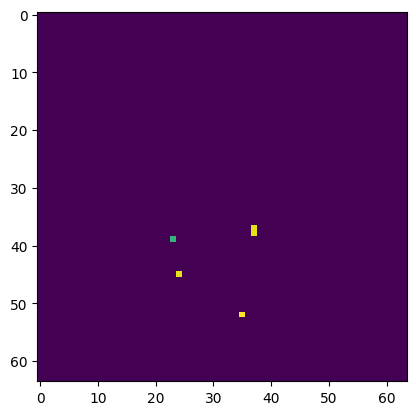

In [75]:
plt.imshow(hy_re_re[16,:,:,2000])

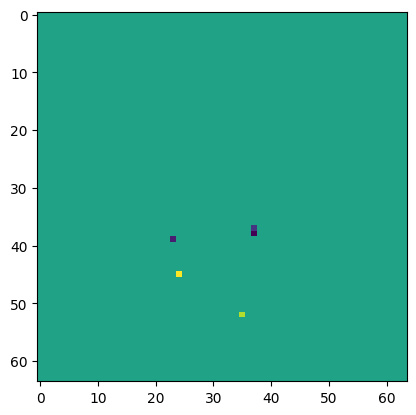

In [76]:
plt.imshow(ms2cpca_re[16,:,:,1])

In [ ]:
plt.scatter(cpca_transformed[1][:,0], cpca_transformed[1][:,1])

In [ ]:
plt.scatter(cpca_transformed3[:,0], cpca_transformed3[:,1])

In [ ]:
#cpca with redone labels with alpha = 3
plt.scatter(cpca_transformed3[:,0], cpca_transformed3[:,1])

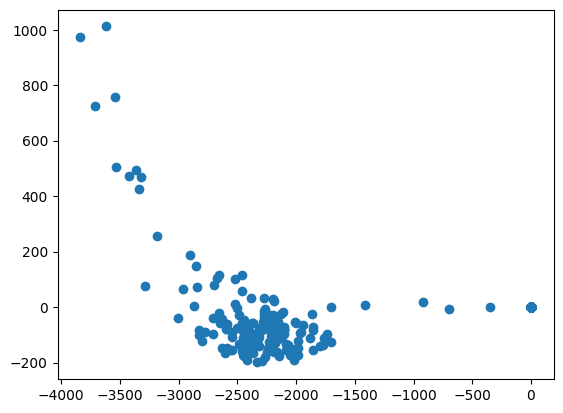

In [7]:
#cpca with redone labels with alpha = 1
labels = [0]*131072+[1]*131072+[2]*131072+[3]*131072
plt.scatter(cpca_transformed4[:,0], cpca_transformed4[:,1])

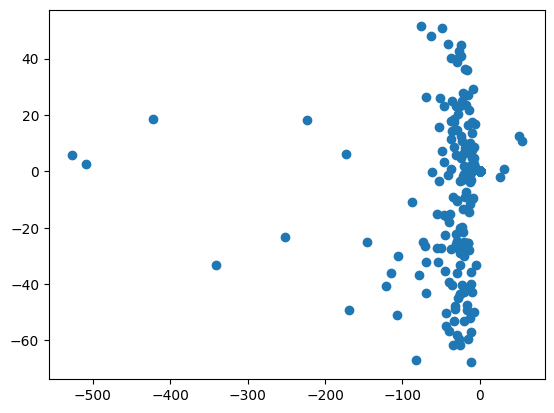

In [8]:
#cpca with redone labels with alpha = 7
plt.scatter(cpca_transformed6[:,0], cpca_transformed6[:,1])

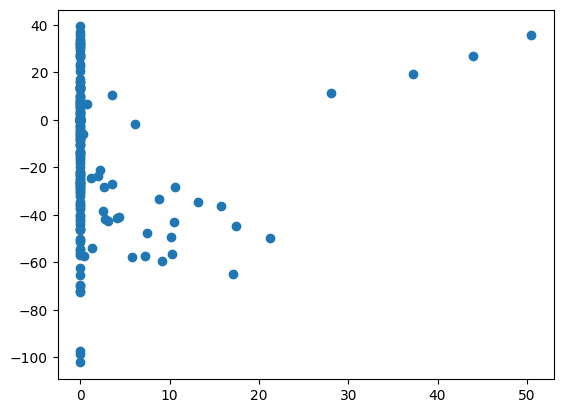

In [127]:
#cpca with redone labels with alpha = 8
plt.scatter(cpca_transformed7[:,0], cpca_transformed7[:,1])

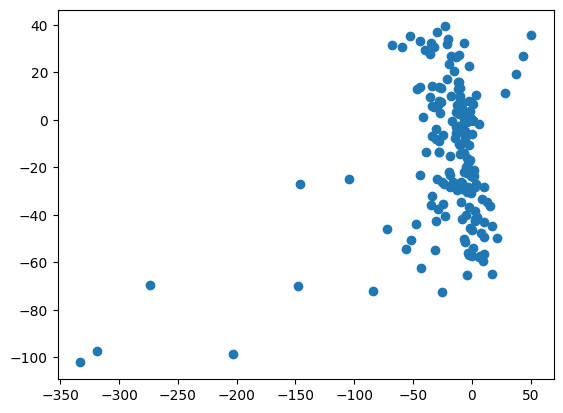

In [80]:
#cpca with redone labels with alpha = 9
plt.scatter(cpca_7_mask_applied[:,0], cpca_7_mask_applied[:,1])

In [ ]:
#cpca with redone labels with alpha = 5
plt.scatter(cpca_transformed5[:,0], cpca_transformed5[:,1])

Kmeans to find clustering of cpca results

In [ ]:
from sklearn.cluster import KMeans

data = list(zip(cpca_transformed3[:,0], cpca_transformed3[:,1]))
inertias = []

for i in range(1,5):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,5), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [ ]:
from sklearn.cluster import KMeans

data = list(zip(cpca_transformed3[:,0], cpca_transformed3[:,1]))
inertias = []

for i in range(1,6):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,6), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(data)

plt.scatter(cpca_transformed3[:,0], cpca_transformed3[:,1], c=kmeans.labels_)
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(data)

plt.scatter(cpca_transformed3[:,0], cpca_transformed3[:,1], c=kmeans.labels_)
plt.show()

In [14]:
from sklearn.cluster import KMeans

data = list(zip(cpca_transformed6[:,0], cpca_transformed6[:,1]))
inertias = []

for i in range(1,10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,10), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

NameError: name 'cpca_transformed6' is not defined

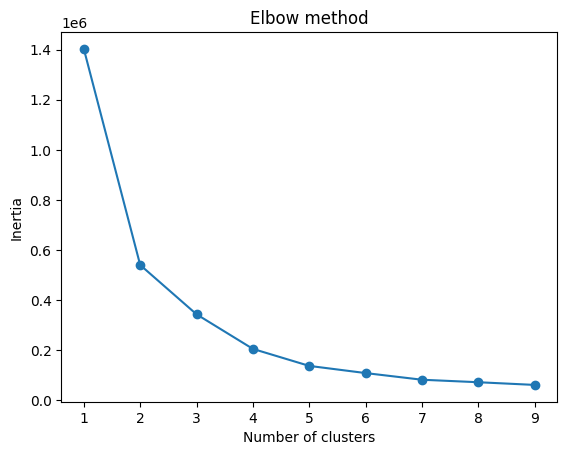

In [10]:
from sklearn.cluster import KMeans

data = list(zip(cpca_transformed6[:,0], cpca_transformed6[:,1]))
inertias = []

for i in range(1,10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,10), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

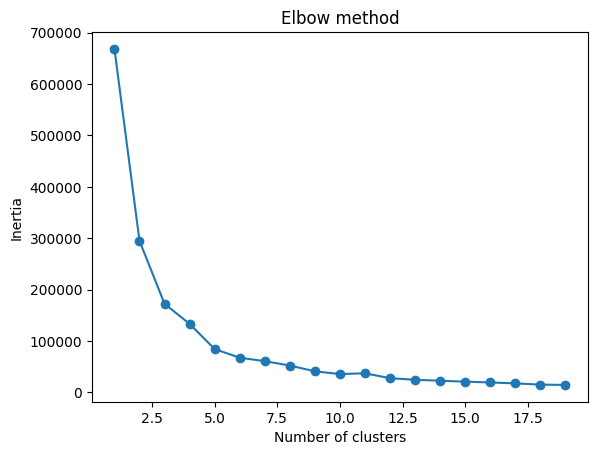

In [33]:
from sklearn.cluster import KMeans

data = list(zip(cpca_transformed7[:,0], cpca_transformed7[:,1]))
inertias = []

for i in range(1,20):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,20), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [36]:
cpca_transformed7[:,0].shape

(524288,)

In [41]:
cpca_7=cpca_transformed7.copy()

In [43]:
cpca_7[:,0].shape

(524288,)

In [37]:
#removing small numbers from cpca a=8
msl1_arr_re = msl1_arr.reshape(32*64*64)
msl2_arr_re = msl2_arr.reshape(32*64*64)
msl3_arr_re = msl3_arr.reshape(32*64*64)
msl5_arr_re = msl5_arr.reshape(32*64*64)
msl_frame = np.reshape(np.concatenate((msl1_arr_re, msl2_arr_re, msl3_arr_re, msl5_arr_re), axis=0), (524288, 1))

In [38]:
msl_frame.shape

(524288, 1)

In [49]:
cpca_7_temp = np.ma.masked_where(msl_frame<1, cpca_7[:,0].reshape(524288,1)) #mask values that are less than 1 in spectral data (gives hyperintensities)
cpca_7_temp_mask = np.ma.getmask(cpca_7_temp) #get only mask (True False) values
cpca_7_temp_mask_applied = np.where(cpca_7_temp_mask, 0, cpca_7_temp) #where mask is True (and value is 'masked'), make it 0 and keep everything else

In [69]:
cpca_7_temp2 = np.ma.masked_where(msl_frame<1, cpca_7[:,1].reshape(524288,1)) #mask values that are less than 1 in spectral data (gives hyperintensities)
cpca_7_temp_mask2 = np.ma.getmask(cpca_7_temp2) #get only mask (True False) values
cpca_7_temp_mask_applied2 = np.where(cpca_7_temp_mask2, 0, cpca_7_temp2) #where mask is True (and value is 'masked'), make it 0 and keep everything else

In [65]:
cpca_7[:,0].reshape(524288,1)[200000]

array([0.00696766])

In [66]:
cpca_7_temp_mask_applied[200000]

array([0.])

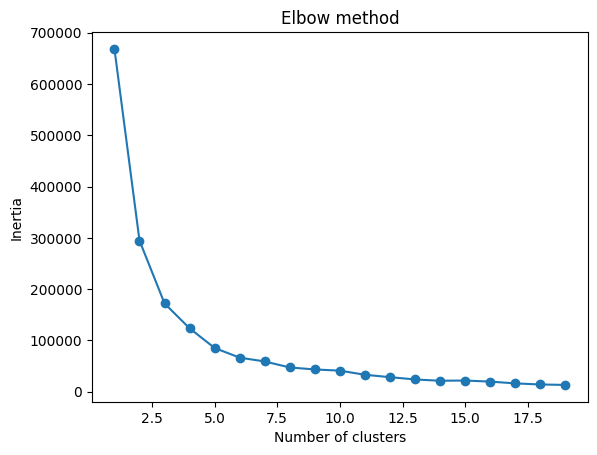

In [62]:
from sklearn.cluster import KMeans

data = list(zip(cpca_7_temp_mask_applied.reshape(524288), cpca_7_temp_mask_applied2.reshape(524288)))
inertias = []

for i in range(1,20):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,20), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

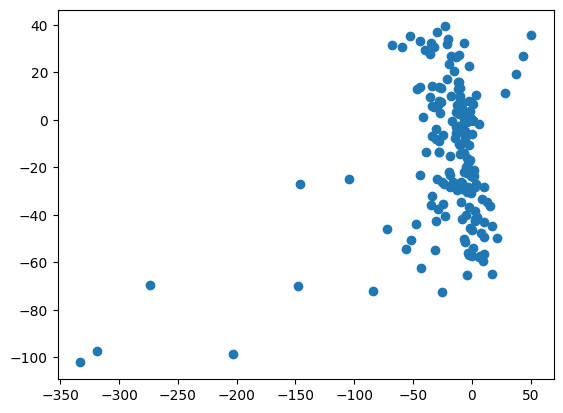

In [70]:
plt.scatter(cpca_7_temp_mask_applied.reshape(524288), cpca_7_temp_mask_applied2.reshape(524288))

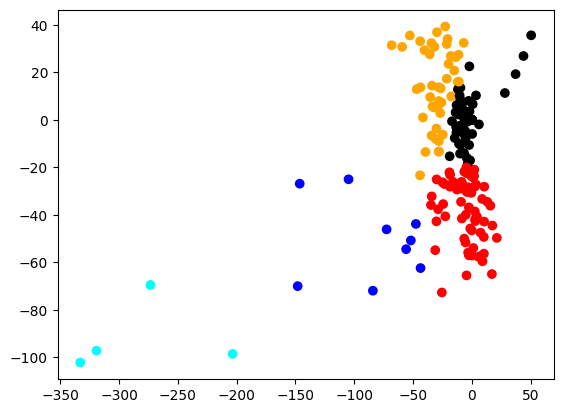

In [84]:
kmeans = KMeans(n_clusters=5, algorithm='elkan', random_state=5)
data_clusters = kmeans.fit_predict(data)

LABEL_COLOR_MAP = {0:'black', 1 : 'cyan' ,2 : 'orange', 3: 'red', 4: 'blue', 5: 'yellow', 6: 'purple', 7:'green', 8: 'indigo'}
label_color=[LABEL_COLOR_MAP[l] for l in data_clusters]

plt.scatter(cpca_transformed7[:,0], cpca_transformed7[:,1], c=label_color)
plt.show()

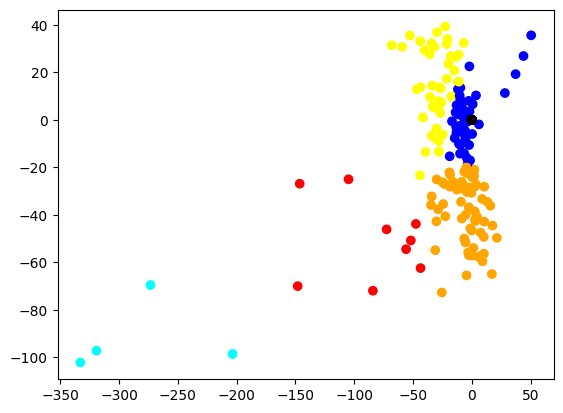

In [131]:
LABEL_COLOR_MAP = {0:'black', 1 : 'blue' ,2 : 'cyan', 3: 'yellow', 4: 'orange', 5: 'red', 6: 'purple', 7:'green', 8: 'indigo'}
label_color=[LABEL_COLOR_MAP[l] for l in labels_temp_mask_applied.reshape(524288)]

plt.scatter(cpca_transformed7[:,0], cpca_transformed7[:,1], c=label_color)
plt.show()

In [43]:
labels = [0]*131072+[1]*131072+[2]*131072+[3]*131072
plt.scatter(cpca_transformed7[:,0], cpca_transformed7[:,1], cmap = labels)

NameError: name 'cpca_transformed7' is not defined

In [85]:
(kmeans.labels_ == data_clusters).all()

np.True_

In [86]:
labels = np.reshape(data_clusters, (524288,1))

In [96]:
labels_1 = labels + 1

In [93]:
#removing small numbers from cpca a=8
msl1_arr_re = msl1_arr.reshape(32*64*64)
msl2_arr_re = msl2_arr.reshape(32*64*64)
msl3_arr_re = msl3_arr.reshape(32*64*64)
msl5_arr_re = msl5_arr.reshape(32*64*64)
msl_frame = np.reshape(np.concatenate((msl1_arr_re, msl2_arr_re, msl3_arr_re, msl5_arr_re), axis=0), (524288, 1))

In [99]:
labels_temp = np.ma.masked_where(msl_frame<1, labels_1) #mask values that are less than 1 in spectral data (gives hyperintensities)
labels_temp_mask = np.ma.getmask(labels_temp) #get only mask (True False) values
labels_temp_mask_applied = np.where(labels_temp_mask, 0, labels_temp) #where mask is True (and value is 'masked'), make it 0 and keep everything else

In [100]:
labels_temp_mask_applied.shape

(524288, 1)

In [101]:
np.unique_values(labels_temp_mask_applied)

array([0, 1, 2, 3, 4, 5], dtype=int32)

In [87]:
unique_values, counts = np.unique(labels, return_counts=True)

print(unique_values) 
print(counts)

[0 1 2 3 4]
[524167      4     44     64      9]


In [103]:
unique_values, counts = np.unique(labels_temp_mask_applied, return_counts=True)

print(unique_values) 
print(counts)

[0 1 2 3 4 5]
[524123     44      4     44     64      9]


In [88]:
hy_frame.shape

(524288, 2048)

In [104]:
#adding labels column to data
hy_frame_wlabel = np.append(hy_frame, labels_temp_mask_applied, axis = 1)

In [25]:
hy_frame_wlabel.shape

(524288, 2049)

In [66]:
ms1_arr_masked_hy = np.load('/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS01/redo/ms1_arr_masked_hy_re_ws.npy')

In [ ]:
ms2_arr_masked_hy = np.load('/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS02/redo/ms2_arr_masked_hy_new.npy')

In [67]:
ms1_arr_masked_hy_re = ms1_arr_masked_hy.reshape(32,64,64,2048)

In [105]:
#separating out labeled data
ms1_arr_hy_wlabels = hy_frame_wlabel[0:131072]
ms2_arr_hy_wlabels = hy_frame_wlabel[131072:262144]
ms3_arr_hy_wlabels = hy_frame_wlabel[262144:393216]
ms5_arr_hy_wlabels = hy_frame_wlabel[393216:524288]

In [106]:
ms1_arr_hy_wlabels.shape

(131072, 2049)

In [107]:
ms1_arr_hy_wlabels_re = ms1_arr_hy_wlabels.reshape(32,64,64,2049)
ms2_arr_hy_wlabels_re = ms2_arr_hy_wlabels.reshape(32,64,64,2049)
ms3_arr_hy_wlabels_re = ms3_arr_hy_wlabels.reshape(32,64,64,2049)
ms5_arr_hy_wlabels_re = ms5_arr_hy_wlabels.reshape(32,64,64,2049)

In [111]:
#saving (samples, features for CPCA)
import nibabel as nib
ni_img = nib.Nifti1Image(ms1_arr_hy_wlabels_re, affine=np.eye(4))
nib.save(ni_img, "/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS01/redo/ms1_arr_hy_wlabels_reshaped_labelswspectra_ws.nii")

In [42]:
ms1_arr_hy_wlabels_re.shape

(32, 64, 64, 2049)

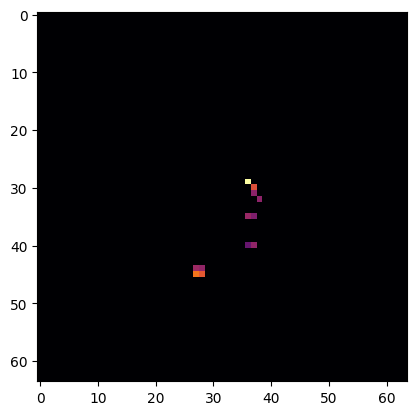

In [114]:
plt.imshow(ms1_arr_hy_wlabels_re[14,:,:,750],cmap='inferno')

In [45]:
ms1_arr_hy_wlabels_re.shape

(32, 64, 64, 2049)

In [121]:
ms1_arr_hy_wlabels_re_onlylabels = ms1_arr_hy_wlabels_re[:,:,:,2048]
ms2_arr_hy_wlabels_re_onlylabels = ms2_arr_hy_wlabels_re[:,:,:,2048]
ms3_arr_hy_wlabels_re_onlylabels = ms3_arr_hy_wlabels_re[:,:,:,2048]
ms5_arr_hy_wlabels_re_onlylabels = ms5_arr_hy_wlabels_re[:,:,:,2048]

In [122]:
np.unique(ms1_arr_hy_wlabels_re_onlylabels)

array([0., 1., 2., 3., 4., 5.])

In [123]:
np.unique(ms2_arr_hy_wlabels_re_onlylabels)

array([0., 1., 3., 4., 5.])

In [124]:
np.unique(ms3_arr_hy_wlabels_re_onlylabels)

array([0., 1., 3., 4., 5.])

In [125]:
np.unique(ms5_arr_hy_wlabels_re_onlylabels)

array([0., 1., 3., 4.])

In [130]:
#saving (samples, features for CPCA)
import nibabel as nib
ni_img = nib.Nifti1Image(ms5_arr_hy_wlabels_re_onlylabels, affine=np.eye(4))
nib.save(ni_img, "/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS05/redo/ms5_arr_hy_wlabels_re_onlylabels_4c_ws.nii")

In [ ]:
#saving (samples, features for CPCA)
import nibabel as nib
ni_img = nib.Nifti1Image(ms1_arr_masked_hy[:,:,:,1000], affine=np.eye(4))
nib.save(ni_img, "/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS01/redo/ms1_arr_masked_hy_new.nii")

In [ ]:
ms1_arr_hy_wlabels_re_onlylabels = nib.load("/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS01/redo/ms1_arr_hy_wlabels_re_onlylabels_4c.nii").dataobj
ms2_arr_hy_wlabels_re_onlylabels = nib.load("/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS02/redo/ms2_arr_hy_wlabels_re_onlylabels_4c.nii").dataobj
ms3_arr_hy_wlabels_re_onlylabels = nib.load("/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS03/redo/ms3_arr_hy_wlabels_re_onlylabels_4c.nii").dataobj
ms5_arr_hy_wlabels_re_onlylabels = nib.load("/data/MRSI/Naren2/FURI2/mayomrs_aligned/ms/RMS05/redo/ms5_arr_hy_wlabels_re_onlylabels_4c.nii").dataobj

In [ ]:
flair_test_ss_2 = np.array(nib.load('/data/MRSI/Naren2/FURI2/mayomrs_aligned/NarenTemplateSpace/RMS02_flair_ss_256.nii').dataobj)

In [ ]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(data)

plt.scatter(cpca_transformed3[:,0], cpca_transformed3[:,1], c=kmeans.labels_)
plt.show()

In [ ]:
np.save('/data/bioprotean/Naren2/FURI2/mayomrs_aligned/CPCA/RMS01_RMS02_CPCA_Alpha3.npy',cpca_transformed3)

In [ ]:
plt.scatter(cpca_transformed2[:,0], cpca_transformed2[:,1])

In [ ]:
cpca_transformed[0]

In [ ]:
#attempting to separate all hyperintensities from control background, black is hyperintensities, each color is diff pt.
cpca2 = CPCA()
labels2 = [0]*524288+[1]*131072+[2]*131072+[3]*131072+[4]*131072
cpca_transformed2 = cpca.fit_transform(hy_frame_allms.real, bgd_frame_onlyc.real, plot=True, active_labels=labels2, n_alphas=10)
#preprocess_with_pca_dim=500

In [ ]:
#attempting to separate all hyperintensities from control background, red is control, black is hyperintensities
cpca2 = CPCA()
labels2 = [0]*524288+[1]*524288
cpca_transformed2 = cpca2.fit_transform(hy_frame_allms.real, bgd_frame_onlyc.real, plot=True, active_labels=labels2, n_alphas=10, preprocess_with_pca_dim=500)

In [ ]:
#hy_frame is only hyperintensity spectra to see how each brain separates from one another
cpca2 = CPCA()
labels2 = [0]*131072+[1]*131072+[2]*131072+[3]*131072
cpca_transformed2 = cpca2.fit_transform(hy_frame.real, bgd_frame_onlyc.real, plot=True, active_labels=labels2, n_alphas=10, preprocess_with_pca_dim=500)

In [ ]:
#hy_test is only 1st and 2nd MS brains, with first 250k being hyperintensties spectra, and second 250k being control background spectra
#hy_test was used to reduce data size
cpca2 = CPCA()
labels2 = [0]*262144+[1]*262144
cpca_transformed2 = cpca2.fit_transform(hy_test.real, bgd_frame_onlyc.real, plot=True, active_labels=labels2, n_alphas=10, preprocess_with_pca_dim=500)

In [ ]:
#without standardizing
cpca2 = CPCA(standardize=False, verbose=True)
labels2 = [0]*262144+[1]*262144
cpca_transformed2 = cpca2.fit_transform(hy_test.real, bgd_frame_onlyc.real, plot=True, active_labels=labels2, n_alphas=10, preprocess_with_pca_dim=500)

In [ ]:
cpca2 = CPCA(verbose=True)
labels2 = [1]*262144+[0]*262144
cpca_transformed2 = cpca2.fit_transform(hy_test.real, bgd_frame_onlyc.real, plot=True, active_labels=labels2, n_alphas=10, preprocess_with_pca_dim=500)

In [ ]:
np.count_nonzero(hy_test==0)

In [ ]:
#only ms with bgd outside ms hy
cpca2 = CPCA(verbose=True)
labels2 = [0]*131072+[1]*131072+[2]*131072+[3]*131072
cpca_transformed2 = cpca2.fit_transform(hy_test.real, bgd_onlyms.real, plot=True, active_labels=labels2, n_alphas=10, preprocess_with_pca_dim=500)